# Self-Balancing Scooter Control

![](images/self-balancing-scooter.png)

> A self-balancing scooter [...] is a self-balancing personal transporter consisting of two motorized wheels connected to a pair of articulated pads on which the rider places their feet. The rider controls the speed by leaning forward or backward, and direction of travel by twisting the pads.
>
> Source: <https://en.wikipedia.org/wiki/Self-balancing_scooter>


### Python Dependencies


In [10]:
import numpy as np
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *


import matplotlib.pyplot as plt

from matplotlib.pyplot import *
from matplotlib import patches

# Step 1 - Scooter Planar Model


### Introduction


We consider a simple model of a self-balancing scooter evolving in the plane. It is mainly made of

- The frame that contains the two articulated pads; from above, each pad essentially look like a triangle (one vertice in the center of the frame, one vertice at each extremity of the wheel).

- Two fixed wheels (their orientation with respect to the frame does not change).
  They are parallel and located at opposite ends of the frame.

Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote

- $(x, y)$ the coordinates of the wheel axis center in the orthonormal and
- $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the scooter faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

- $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the scooter moves forward.


### Parameter Definition


From now on, we assume that the seat frame length is $\ell = 50 \mbox{cm}$ and the wheel radius is $r = 12.5 \mbox{ cm}$.

🧩 Define the corresponding Python variables `l` and `r` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values.


In [11]:
l = 0.5
r = 0.125

### Graphical Representation

🧩 Implement a function `draw_scooter` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with a red frame and black fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. Use a green circle marker 50 cm in of the frame to indicate which way is forward.

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.


In [12]:
def draw_scooter(x, y, theta):

    xr = x + np.sin(theta) * l / 2  # Calculate x-coordinate of the right wheel
    yr = y - np.cos(theta) * l / 2  # Calculate y-coordinate of the right wheel


    xl = x - np.sin(theta) * l / 2  # Calculate x-coordinate of the left wheel
    yl = y + np.cos(theta) * l / 2  # Calculate y-coordinate of the left wheel

    points_num = 100  # Number of points to plot for the wheel circumference
    xr_ = np.linspace(xr - r * np.cos(theta), xr + r * np.cos(theta), points_num)  # X-coordinates for right wheel circumference
    yr_ = np.linspace(yr - r * np.sin(theta), yr + r * np.sin(theta), points_num)  # Y-coordinates for right wheel circumference
    xl_ = np.linspace(xl - r * np.cos(theta), xl + r * np.cos(theta), points_num)  # X-coordinates for left wheel circumference
    yl_ = np.linspace(yl - r * np.sin(theta), yl + r * np.sin(theta), points_num)  # Y-coordinates for left wheel circumference

    # Define the polygon for the right wheel
    patch_r = patches.Polygon(
        [
            (x, y),  # Center point
            (xr + r * np.cos(theta), yr - r * np.sin(theta)),  # Right top point
            (xr - r * np.cos(theta), yr + r * np.sin(theta)),  # Right bottom point
        ],
        closed=True,
        edgecolor="red",  # Red edge color
        facecolor="red",  # Red face color
    )

    # Define the polygon for the left wheel
    patch_l = patches.Polygon(
        [
            (x, y),  # Center point
            (xl + r * np.cos(theta), yl - r * np.sin(theta)),  # Left top point
            (xl - r * np.cos(theta), yl + r * np.sin(theta)),  # Left bottom point
        ],
        closed=True,
        edgecolor="red",  # Red edge color
        facecolor="red",  # Red face color
    )

    plt.plot(xl_, yl_, "ko")  # Plot the left wheel as black circles
    plt.plot(xr_, yr_, "ko")  # Plot the right wheel as black circles
    plt.plot(x + 0.5 * np.cos(theta), y + 0.5 * np.sin(theta), "go")  # Plot the scooter's center as a green dot

    plt.gca().add_patch(patch_r)  # Add the right wheel polygon to the plot
    plt.gca().add_patch(patch_l)  # Add the left wheel polygon to the plot


🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.


In [13]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax + 1, 1))
    yticks(arange(ymin, ymax + 1, 1))
    grid(True)

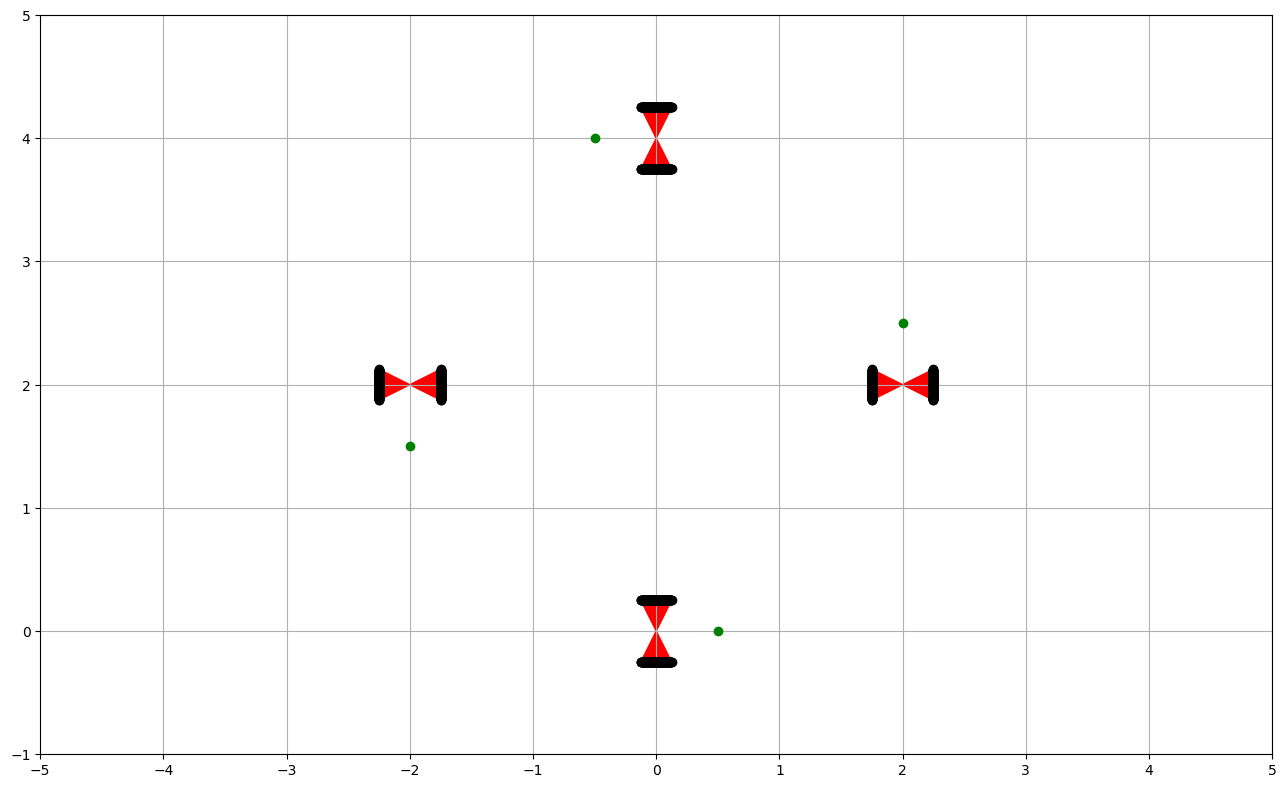

In [14]:
draw_arena(-5, 5, -1, 5)
draw_scooter(0, 0, 0)
draw_scooter(2, 2, np.pi / 2)
draw_scooter(0, 4, np.pi)
draw_scooter(-2, 2, 3 * np.pi / 2)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a _kinematic_ model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping.

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.


**TODO**


### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.


**TODO**


🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?


**TODO**


### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:


In [6]:
def omega(t, xytheta):
    omega_l = (1 - l / 4) * pi / r
    omega_r = (1 + l / 4) * pi / r
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).


In [1]:
pass

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - \ell/4)  \pi / r \mbox{ rad/s}$ and $\omega_r = (1 + \ell/4)  \pi / r \mbox{ rad/s}$.
(Compute the dense outputs.)


In [2]:
pass

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.


In [3]:
pass

🧩 Use the simulation results to display the robot location every 0.5 second.


In [4]:
pass

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$?


**TODO**


🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.


In [5]:
pass

🧩 If needed, adjust the simulation parameters the simulated position error is less than $1\, \mathrm{ mm}$.


In [6]:
pass